In [12]:
from azure.storage.blob import BlobServiceClient
import os
import io
import tensorflow as tf
import numpy as np

In [19]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "publicdata"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [10]:
#get filepaths

import pandas as pd
df = pd.read_csv("/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/2_Semester/ML/Assignments/machine_learning/ML_Final_Project/preprocessed.csv")

filenames = df["filename"]
labels = np.array(df["Labels"])

###train,test and validation split

In [73]:
image_size=224
channels=1

batch_size = 256 # Big enough to measure an F1-score
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
shuffle_buffer_size = 1024 # Shuffle the training data by a chunck of 1024 observations

In [64]:
def load_image(path):
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    # Convert the blob data to a bytes buffer
    blob = io.BytesIO(blob_data)
    # Decode the image data and convert to a TensorFlow tensor
    return blob  #returning the PIL Image object


def process_tensor(path,label):
    """
    Function to parse a blob image into a normalized tensor and return it with labels.

    Args:
        blob: Blob image data as a byte string.
        label: 0/1 one-dimensional array of size N_LABELS.
        img_size: Integer, the size to which the image is resized (default is 224).
        channels: Integer, the number of image channels (default is 3 for RGB).

    Returns:
        A tuple (image_normalized, label) where image_normalized is a tf.Tensor.
    """
    #load and return blob
    #blob = load_image(path)
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    # Convert the blob data to a bytes buffer
    blob = io.BytesIO(blob_data)
    
    # Convert blob to a tensor
    image_tensor = tf.io.decode_image(blob.getvalue(), channels=channels)

    # Resize the image to the specified size
    image_resized = tf.image.resize(image_tensor, [image_size, image_size])

    # Normalize the image data to [0, 1]
    image_normalized = image_resized / 255.0

    return image_normalized, label

def create_dataset(filenames, labels, is_training=False):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(process_tensor, num_parallel_calls=autotune)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(batch_size)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=autotune)
    
    return dataset

In [77]:
import tensorflow as tf
import io
from azure.storage.blob import BlobServiceClient, ContainerClient


def load_image(path):
    """Load an image from Azure Blob Storage."""
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    return io.BytesIO(blob_data)

def load_and_preprocess_image(path):
        # Load image
        image_file = load_image(path.numpy().decode('utf-8'))
        # Decode the image
        image_tensor = tf.io.decode_image(image_file.getvalue(), channels=channels)
        # Resize the image
        image_resized = tf.image.resize(image_tensor, [224, 224])
        # Normalize the image data
        image_normalized = image_resized / 255.0
        return image_normalized

def process_tensor(path, label):
    """Function to load an image from blob storage, decode, resize, and normalize it."""

    image_normalized = tf.py_function(load_and_preprocess_image, [path], tf.float32)
    # Ensure the shape is set correctly
    image_normalized.set_shape([224, 224, 1])
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Creates a TensorFlow dataset from filenames and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.cache()  # Cache the data for faster subsequent reads
        dataset = dataset.shuffle(buffer_size=1024)  # Shuffle the dataset
        
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [78]:
train_ds = create_dataset(filenames, labels)

In [79]:
import tensorflow as tf

# Assuming 'create_dataset' function has already been defined and used
# Example: train_ds = create_dataset(filenames, labels, is_training=True)

for images, labels in train_ds.take(1):  # Here, take(1) takes the first batch
    print("Images:", images.numpy())  # Convert tensor to numpy array and print
    print("Labels:", labels.numpy())  # Convert tensor to numpy array and print


2024-05-07 20:12:41.851632: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [50]
	 [[{{node Placeholder/_1}}]]
2024-05-07 20:12:41.852102: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [50]
	 [[{{node Placeholder/_1}}]]


Images: [[[[0.14516307]
   [0.1340061 ]
   [0.12950431]
   ...
   [0.47737086]
   [0.3721808 ]
   [0.5638239 ]]

  [[0.16465837]
   [0.13015707]
   [0.12079582]
   ...
   [0.30603886]
   [0.24886954]
   [0.51375693]]

  [[0.12409964]
   [0.14733893]
   [0.12651311]
   ...
   [0.20596023]
   [0.21239552]
   [0.26553306]]

  ...

  [[0.39879596]
   [0.32261875]
   [0.33087435]
   ...
   [0.41205794]
   [0.33133596]
   [0.40324438]]

  [[0.33729738]
   [0.36859205]
   [0.43373322]
   ...
   [0.4865564 ]
   [0.32294592]
   [0.35441902]]

  [[0.39642757]
   [0.39167887]
   [0.41516307]
   ...
   [0.35601005]
   [0.32954556]
   [0.37734136]]]


 [[[0.70687777]
   [0.69962233]
   [0.6885504 ]
   ...
   [0.39607844]
   [0.40791318]
   [0.40585235]]

  [[0.68309826]
   [0.70446926]
   [0.6380027 ]
   ...
   [0.40143558]
   [0.40927872]
   [0.39985985]]

  [[0.7002101 ]
   [0.68370855]
   [0.6657638 ]
   ...
   [0.40784314]
   [0.42577296]
   [0.40799567]]

  ...

  [[0.33716196]
   [0.27464694]

2024-05-07 20:12:58.386387: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [50]
	 [[{{node Placeholder/_1}}]]
2024-05-07 20:12:58.386704: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]


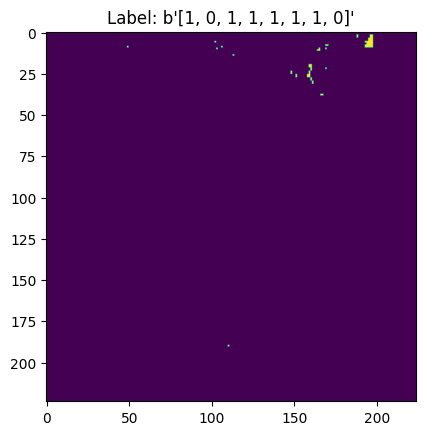

In [80]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))  # Visualize the first image of the batch
    plt.title(f"Label: {labels[0].numpy()}")
    plt.show()


### Self Trained VGG
Source: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

import tensorflow as tf

_input = Input((224,224,1)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(8, activation="sigmoid")(dense2) #adapted number of outputs and outputfunction

vgg16_model  = Model(inputs=_input, outputs=output)

In [22]:
#compile the model
vgg16_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
##provide a model summary
vgg16_model.summary()

In [ ]:
#fit the model
vgg16_model.fit(
    
)

### Pre Trained VGG
Source: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

In [ ]:

from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt 
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import os 

img1 = "../input/flowers-recognition/flowers/tulip/10094729603_eeca3f2cb6.jpg"
img2 = "../input/flowers-recognition/flowers/dandelion/10477378514_9ffbcec4cf_m.jpg"
img3 = "../input/flowers-recognition/flowers/sunflower/10386540696_0a95ee53a8_n.jpg"
img4 = "../input/flowers-recognition/flowers/rose/10090824183_d02c613f10_m.jpg"
imgs = [img1, img2, img3, img4]

def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 

def _get_predictions(_model):
    f, ax = plt.subplots(1, 4)
    f.set_size_inches(80, 40)
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((200, 200), Image.ANTIALIAS))
    plt.show()
    
    f, axes = plt.subplots(1, 4)
    f.set_size_inches(80, 20)
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path)
        preds  = decode_predictions(_model.predict(img), top=3)[0]
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="gray", ax=axes[i])
        b.tick_params(labelsize=55)
        f.tight_layout()

### Pre Trained Weights

In [ ]:

from keras.applications.vgg16 import VGG16
vgg16_weights = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)
_get_predictions(vgg16_model)

'''
Downloading data from https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
40960/35363 [==================================] - 0s 0us/step
'''


https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104

In [2]:
class RockPaperScissorsVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 3
        self.model = None
        self.build_model()

    def build_model(self):
        vgg16 = VGG16(weights='imagenet', input_shape=self.input_shape, classes=self.classes, include_top=False)

        for layer in vgg16.layers:
            layer.trainable = False

        x = Flatten()(vgg16.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.classes, activation='softmax')(x)

        self.model = Model(inputs=vgg16.input, outputs=predictions)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train_vgg16(train_images, train_labels) -> Model:
        vgg16 = RockPaperScissorsVgg16(INPUT_WIDTH, INPUT_HEIGHT)
        model = vgg16.model
        model.summary()

        train_generator, validation_generator = get_generators(train_images, train_labels)

        model.fit(
            train_generator,
            steps_per_epoch=40,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=10,
            callbacks=[StopByAccuracyCallback()]
        )

        return model

In [1]:
import pandas as pd
df = pd.read_csv("/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/2_Semester/ML/Assignments/machine_learning/ML_Final_Project/preprocessed.csv")

In [2]:
df

,Unnamed: 0,filename,Human,Barrier,Bike,Motorcycle,Truck,Car,Trafficcone,NoDetec,Labels,image
0,0,samples/CAM_BACK/n003-2018-01-03-12-03-23+0800...,1,0,0,1,1,1,0,0,"[1, 0, 0, 1, 1, 1, 0, 0]",[[0.28235294 0.30196078 0.30196078 ... 0.70588...
1,1,samples/CAM_BACK/n003-2018-01-08-11-30-34+0800...,1,1,0,1,1,1,0,0,"[1, 1, 0, 1, 1, 1, 0, 0]",[[0.21960784 0.22745098 0.23921569 ... 0.36078...
2,2,samples/CAM_BACK/n003-2018-07-12-15-40-35+0800...,1,0,0,1,0,1,0,0,"[1, 0, 0, 1, 0, 1, 0, 0]",[[0.46666667 0.4627451 0.4627451 ... 0.75686...
3,3,samples/CAM_BACK/n005-2018-06-14-20-11-03+0800...,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 1, 0, 0]",[[0.06666667 0.04705882 0.05882353 ... 0.08627...
4,4,samples/CAM_BACK/n008-2018-06-04-16-30-00-0400...,0,0,0,0,1,1,0,0,"[0, 0, 0, 0, 1, 1, 0, 0]",[[0.38039216 0.37254902 0.33333333 ... 0.35686...
5,5,samples/CAM_BACK/n009-2018-05-08-15-52-41-0400...,0,0,1,0,1,1,0,0,"[0, 0, 1, 0, 1, 1, 0, 0]",[[0.3372549 0.33333333 0.31372549 ... 0.66274...
6,6,samples/CAM_BACK/n010-2018-08-27-12-00-23+0800...,1,1,0,0,1,1,0,0,"[1, 1, 0, 0, 1, 1, 0, 0]",[[0.19215686 0.22352941 0.22745098 ... 0.29411...
7,7,samples/CAM_BACK/n013-2018-08-20-14-38-24+0800...,0,0,1,0,1,1,0,0,"[0, 0, 1, 0, 1, 1, 0, 0]",[[0.22352941 0.25490196 0.22745098 ... 0.18431...
8,8,samples/CAM_BACK/n013-2018-08-21-11-46-25+0800...,1,0,0,0,0,1,0,0,"[1, 0, 0, 0, 0, 1, 0, 0]",[[0.44313725 0.50196078 0.49803922 ... 0.36470...
9,9,samples/CAM_BACK/n013-2018-08-28-16-04-27+0800...,1,0,0,0,0,1,0,0,"[1, 0, 0, 0, 0, 1, 0, 0]",[[0.15686275 0.18431373 0.17254902 ... 0.25490...


In [5]:
image = df.image[1]
type(image)

str